时序差分和策略迭代的结合体

action模型根据state计算动作,value模型评估动作的价值,有点像GAN的思路

使用delay模型,类似DQN的双模型的思路,缓解自举

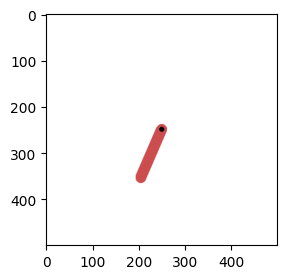

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(
            [action * 2])
        over = terminated or truncated

        #偏移reward,便于训练
        reward = (reward + 8) / 8

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch


class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )

    def forward(self, state):
        return self.s(state)


model_action = Model()
model_action_delay = Model()
model_action_delay.load_state_dict(model_action.state_dict())

model_action(torch.randn(2, 3))

tensor([[-0.0621],
        [-0.0076]], grad_fn=<TanhBackward0>)

In [3]:
model_value = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_value_delay = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_value_delay.load_state_dict(model_value.state_dict())

model_value(torch.randn(2, 4))

tensor([[0.0907],
        [0.0147]], grad_fn=<AddmmBackward0>)

In [4]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model_action(torch.FloatTensor(state).reshape(1, 3)).item()

        #给动作添加噪声,增加探索
        action += random.normalvariate(mu=0, sigma=0.2)

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]


d:\it_project\github_sync\ml-workshop\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


60.304840553240346

In [5]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)
        action = torch.FloatTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 3)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
state, action, reward, next_state, over = pool.sample()

next_state.shape, len(pool), pool[0]

C:\Users\User\AppData\Local\Temp\ipykernel_51344\1738991660.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)


(torch.Size([64, 3]),
 200,
 (array([-0.9773406 ,  0.21167292, -0.3620497 ], dtype=float32),
  0.02832080170760687,
  -0.0735111301950071,
  array([-0.97523254,  0.22118196, -0.19479877], dtype=float32),
  False))

In [6]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-4)
optimizer_value = torch.optim.Adam(model_value.parameters(), lr=5e-3)


def soft_update(_from, _to):
    for _from, _to in zip(_from.parameters(), _to.parameters()):
        value = _to.data * 0.99 + _from.data * 0.01
        _to.data.copy_(value)


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)


requires_grad(model_action_delay, False)
requires_grad(model_value_delay, False)

In [7]:
def train_action(state):
    requires_grad(model_action, True)
    requires_grad(model_value, False)

    #首先把动作计算出来
    action = model_action(state)

    #使用value网络评估动作的价值,价值是越高越好
    input = torch.cat([state, action], dim=1)
    loss = -model_value_delay(input).mean()

    loss.backward()
    optimizer_action.step()
    optimizer_action.zero_grad()

    return loss.item()


train_action(state)

-0.025642042979598045

In [8]:
def train_value(state, action, reward, next_state, over):
    requires_grad(model_action, False)
    requires_grad(model_value, True)

    #计算value
    input = torch.cat([state, action], dim=1)
    value = model_value(input)

    #计算target
    with torch.no_grad():
        next_action = model_action_delay(next_state)
        input = torch.cat([next_state, next_action], dim=1)
        target = model_value_delay(input)
    target = target * 0.99 * (1 - over) + reward

    #计算td loss,更新参数
    loss = torch.nn.functional.mse_loss(value, target)

    loss.backward()
    optimizer_value.step()
    optimizer_value.zero_grad()

    return loss.item(), value.mean().item()


train_value(state, action, reward, next_state, over)

(0.034272558987140656, 0.027186142280697823)

In [9]:
#训练
def train():
    model_action.train()
    model_value.train()

    #共更新N轮数据
    for epoch in range(200):
        pool.update()

        #每次更新数据后,训练N次
        for i in range(200):

            #采样N条数据
            state, action, reward, next_state, over = pool.sample()

            #训练模型
            train_action(state)
            _, value = train_value(state, action, reward, next_state, over)

            soft_update(model_action, model_action_delay)
            soft_update(model_value, model_value_delay)

        if epoch % 20 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, len(pool), value, test_result)


train()

0 400 -0.029529720544815063 24.432837840165426
20 4400 15.282708168029785 179.17425615787425
40 8400 37.549068450927734 178.46754904327108
60 12400 58.288124084472656 178.81315414926698
80 16400 67.79849243164062 178.20344450725324
100 20000 71.95288848876953 174.9730634475033
120 20000 73.81578063964844 163.96338066916286
140 20000 72.11185455322266 148.8371742053002
160 20000 69.04269409179688 164.7330525838947
180 20000 66.14569854736328 177.99978142515323


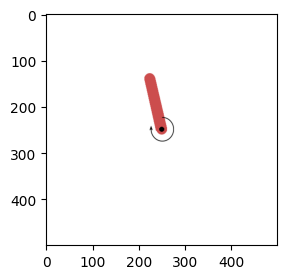

183.12489338558873

In [10]:
play(True)[-1]